In [136]:
import pandas as pd
import numpy as np
import re
#from googletrans import Translator
pd.set_option('display.max_columns', 100)
#pd.set_option('display.max_colwidth', None)
from googletrans import Translator, constants
pd.options.display.float_format = '{:,.2f}'.format

In [137]:
df = pd.read_csv('/content/bikroy_raw.csv')

In [138]:
df.shape

(9981, 11)

In [139]:
df.isnull().sum()

area                    1482
building_type           6520
commercial_type            0
completion_status       5124
facing                  5124
location                1605
num_bath_rooms          4943
num_bed_rooms           4943
price                    110
property_description       1
property_url               0
dtype: int64

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9981 entries, 0 to 9980
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   area                  8499 non-null   object
 1   building_type         3461 non-null   object
 2   commercial_type       9981 non-null   bool  
 3   completion_status     4857 non-null   object
 4   facing                4857 non-null   object
 5   location              8376 non-null   object
 6   num_bath_rooms        5038 non-null   object
 7   num_bed_rooms         5038 non-null   object
 8   price                 9871 non-null   object
 9   property_description  9980 non-null   object
 10  property_url          9981 non-null   object
dtypes: bool(1), object(10)
memory usage: 789.6+ KB


In [141]:
# Convert area to consistent format (assuming 1 katha = 1100 sqft)
def convert_area(area_value):
    if isinstance(area_value, str):
        area_str = area_value.replace(',', '')  # Remove commas

        if 'katha' in area_str:
            area_value = float(area_str.split()[0])
            return area_value * 1100
        elif 'sqft' in area_str:
            return float(area_str.split()[0])
    elif isinstance(area_value, float) or isinstance(area_value, int):
        return area_value
    else:
        return np.nan

df['area'] = df['area'].apply(convert_area)

In [142]:
# translated_descriptions = []
# translator = Translator()
# for index, row in df.iterrows():
#     property_description = row['property_description']
#     translation = translator.translate(property_description,src  = 'bn', dest = 'en')
#     translated_descriptions.append(translation.text)

# df['translated_property_description'] = translated_descriptions

In [143]:
amenities_synonyms = {
    "flooring-amenity": ["flooring", "floor"],
    "parking-spaces-amenity": ["parking spaces", "parking"],
    "balcony-or-terrace-amenity": ["balcony", "terrace"],
    "floor-level-amenity": ["floor level"],
    "view-amenity": ["view"],
    "elevators-in-building-amenity": ["elevators", "lifts"],
    "lobby-in-building-amenity": ["lobby"],
    "electricity-backup-amenity": ["electricity backup", "power backup"],
    "cctv-security-amenity": ["cctv", "security cameras"],
    "maintenance-staff-amenity": ["maintenance staff"],
    "cleaning-services-amenity": ["cleaning services"],
    "freehold-amenity": ["freehold"],
    "24-hours-concierge-amenity": ["24-hour concierge", "24-hour reception"],
    "waste-disposal-amenity": ["waste disposal"],
    "double-glazed-windows-amenity": ["double-glazed windows", "double glazing"],
    "broadband-internet-amenity": ["broadband internet", "high-speed internet"],
    "lawn-or-garden-amenity": ["lawn", "garden"],
    "storage-areas-amenity": ["storage areas", "storage rooms"],
    "service-elevators-amenity": ["service elevators", "service lifts"],
    "intercom-amenity": ["intercom"],
    "prayer-room-amenity": ["prayer room", "prayer area"],
    "conference-room-amenity": ["conference room", "meeting room"],
    "first-aid-medical-center-amenity": ["first-aid center", "medical center"],
    "business-center-amenity": ["business center"],
    "facilities-for-disabled-amenity": ["facilities for disabled", "disabled access"],
    "furnished-amenity": ["furnished"],
    "swimming-pool-amenity": ["swimming pool"],
    "steam-room-amenity": ["steam room"],
    "sauna-amenity": ["sauna"],
    "jacuzzi-amenity": ["jacuzzi", "hot tub"],
    "central-heating-amenity": ["central heating"],
    "atm-facility-amenity": ["atm", "cash machine"],
    "cafeteria-or-canteen-amenity": ["cafeteria", "canteen"],
    "barbeque-area-amenity": ["barbeque area", "bbq area"],
    "laundry-facility-amenity": ["laundry facility", "laundry room"],
    "shared-kitchen-amenity": ["shared kitchen", "communal kitchen"],
    "day-care-center-amenity": ["day care center", "childcare center"],
}


In [144]:
def extract_price(price_value):
    # Convert the float value to string
    price_str = str(price_value)
    
    # Remove commas and spaces
    cleaned_price_str = price_str.replace(',', '')
    
    # Extract the numeric value using a regular expression
    match = re.search(r'(\d+)', cleaned_price_str)
    
    if match:
        numeric_value = float(match.group())
    else:
        numeric_value = None
    
    # Extract the part after the numeric value
    price_parts = re.split(r'\d+', cleaned_price_str, maxsplit=1)
    if len(price_parts) > 1:
        after_price = price_parts[1].strip()
    else:
        after_price = None
    
    return numeric_value, after_price

In [145]:
df[['numeric_price', 'price_unit']] = df['price'].apply(extract_price).apply(pd.Series)

In [146]:
df['price_unit'].unique()

array(['/month', 'per katha', 'total price', 'per sqft', '', 'per shotok',
       None, '/year', '/day', 'per bigha'], dtype=object)

In [147]:
def convert_to_sqft_price(price, unit):
    area_conversion_factors = {
        'per katha': 720,  # 1 katha = 720 sqft
        'per bigha': 14400,  # 1 bigha = 20 katha = 20 * 720 sqft
        'per shotok': 1 / 0.0022956820843815,  # 1 shotok = 1 / 0.0022956820843815 sqft
    }
    
    time_conversion_factors = {
        '/day': 30,  # 1 day = 1/30 month
        '/year': 1 / 12,  # 1 year = 12 months
    }
    
    if unit in area_conversion_factors:
        return price / area_conversion_factors[unit]
    elif unit in time_conversion_factors:
        return price * time_conversion_factors[unit]
    else:
        return price

In [148]:
df['price_per_sqft'] = df.apply(lambda row: convert_to_sqft_price(row['numeric_price'], row['price_unit']), axis=1)

In [149]:
df['price_unit'].value_counts()

/month         3456
per katha      2996
total price    1711
per sqft       1401
                133
per shotok      106
/year             9
/day              3
per bigha         3
Name: price_unit, dtype: int64

In [150]:
df['purpose'] = df['price_unit'].apply(lambda x: 'rent' if x in ['/day', '/month', '/year'] else 'sale')

<Axes: >

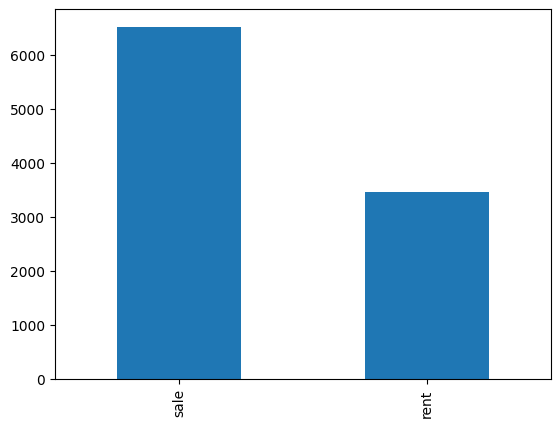

In [151]:
df.purpose.value_counts().plot(kind = 'bar')

In [152]:
# def translate_bengali_to_english(text):
#     translator = Translator(service_urls=['translate.google.com'])
#     translation = translator.translate(text, src='bn', dest='en')
#     return translation.text

# df['property_description_en'] = df['property_description'].apply(translate_bengali_to_english)

In [153]:
# from langdetect import detect

# def is_english(text):
#     try:
#         language = detect(text)
#         return language == 'en'
#     except:
#         return False

# df['is_english'] = df['property_description'].apply(is_english)
# non_english_rows = df[df['is_english'] == False]

# print(f"Number of non-English rows: {len(non_english_rows)}")

In [154]:
def extract_amenities(description, amenities_synonyms):
    extracted_amenities = {}
    
    if isinstance(description, str):
        description = description.lower()
    else:
        description = ''
    
    for amenity, synonyms in amenities_synonyms.items():
        found_amenity = False
        for synonym in synonyms:
            if synonym.lower() in description:
                found_amenity = True
                break
                
        extracted_amenities[amenity] = 'Yes' if found_amenity else 'No'
            
    return extracted_amenities


In [155]:
amenities_df = df['property_description'].apply(lambda x: extract_amenities(x, amenities_synonyms)).apply(pd.Series)

In [156]:
data = pd.concat([df, amenities_df], axis=1)

In [157]:
data.tail()

,area,building_type,commercial_type,completion_status,facing,location,num_bath_rooms,num_bed_rooms,price,property_description,property_url,numeric_price,price_unit,price_per_sqft,purpose,flooring-amenity,parking-spaces-amenity,balcony-or-terrace-amenity,floor-level-amenity,view-amenity,elevators-in-building-amenity,lobby-in-building-amenity,electricity-backup-amenity,cctv-security-amenity,maintenance-staff-amenity,cleaning-services-amenity,freehold-amenity,24-hours-concierge-amenity,waste-disposal-amenity,double-glazed-windows-amenity,broadband-internet-amenity,lawn-or-garden-amenity,storage-areas-amenity,service-elevators-amenity,intercom-amenity,prayer-room-amenity,conference-room-amenity,first-aid-medical-center-amenity,business-center-amenity,facilities-for-disabled-amenity,furnished-amenity,swimming-pool-amenity,steam-room-amenity,sauna-amenity,jacuzzi-amenity,central-heating-amenity,atm-facility-amenity,cafeteria-or-canteen-amenity,barbeque-area-amenity,laundry-facility-amenity,shared-kitchen-amenity,day-care-center-amenity
9976,"1,650.00",NaN,False,Ready,South Facing,NaN,3,4,"Tk 13,500,000 total price","South Facing, Single UnitFlat Sale @ Uttara, S...",https://bikroy.com/en/ad/south-facing-flat-sal...,"13,500,000.00",total price,"13,500,000.00",sale,Yes,Yes,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
9977,"3,300.00",Residential,False,NaN,NaN,"বসুন্ধরা, ব্লকঃ- এল",NaN,NaN,"Tk 8,500,000 per katha","বসুন্ধরা হাউজিং- বারিধারা, ঢাকা ব্লকঃ এল প্লটঃ...",https://bikroy.com/en/ad/dkssinn-mukhii-3-kaat...,"8,500,000.00",per katha,"11,805.56",sale,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
9978,"5,500.00","Commercial, Residential",False,NaN,NaN,NaN,NaN,NaN,"Tk 700,000 per katha",জমিতে বিনিয়োগ মানেই আগামী প্রজন্মের স্বপ্নের আ...,https://bikroy.com/en/ad/bhaiya-grouph-trusted...,"700,000.00",per katha,972.22,sale,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
9979,"3,500.00",NaN,False,Ready,South Facing,50 Baridhara Park road,5,4,"Tk 250,000 /month",*** We committed to provide Excellent Service ...,https://bikroy.com/en/ad/you-can-rent-your-dre...,"250,000.00",/month,"250,000.00",rent,No,Yes,Yes,No,No,No,No,No,Yes,No,No,No,No,No,No,No,Yes,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
9980,"1,075.00",NaN,False,Ready,West Facing,"Prime Location of Sector-05, Uttara.",2,3,"Tk 11,500,000 total price","Well-Ventilated Flat Sale @ Uttara, Sector- 5....",https://bikroy.com/en/ad/well-ventilated-flat-...,"11,500,000.00",total price,"11,500,000.00",sale,Yes,Yes,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No


In [158]:
def get_detailed_address(address):
    if not isinstance(address, str):
        address = str(address)  # Convert the float to a string, or you can return an empty dictionary or other default value.

    address = address.title()
    address_dict = {"City": "", "Area": "","District":"", "Address": ""}
    splitted_address = address.split(',')

    for i in reversed(splitted_address):
        if get_city_name(i.strip()):
            address_dict["City"] = i.strip()
            splitted_address.remove(i)
        elif get_area_name(i.strip()):
            address_dict["Area"] = i.strip()
            splitted_address.remove(i)
        elif get_districts_name(i.strip()):
            address_dict["Area"] = i.strip()
            splitted_address.remove(i)

    address_dict["Address"] = ','.join(splitted_address)

    return address_dict


def get_city_name(name):
    cities = ['Bandar', 'Barishal', 'Bhairab', 'Bogura', 'Brahmanbaria', 'Chandpur', 'Chattogram', 'Chittagong',
                  'Chowmuhani', 'Chuadanga', "Cox's Bazar", 'Cumilla', 'Cumilla Sadar Dakshin', 'Dhaka',
                  'Dinajpur', 'Faridpur', 'Feni', 'Gazipur', 'Jamalpur', 'Jashore', 'Jhenaidah', 'Kaliakair',
                  'Khulna', 'Kishoreganj', 'Kushtia', 'Maijdee', 'Mymensingh', 'Naogaon', 'Narayanganj',
                  'Narsingdi', 'Nawabganj', 'Pabna', 'Rajshahi', 'Rangpur', 'Saidpur', 'Satkhira', 'Savar',
                  'Siddhirganj', 'Sirajganj', 'Sreepur', 'Sylhet', 'Tangail', 'Tarabo', 'Tongi']


    try:
        cities.index(name)
        return True

    except:
        return False
    
def get_districts_name(name):
    districts = ['Bagerhat', 'Bandarban', 'Barguna', 'Barishal', 'Bhola', 'Bogura', 'Brahmanbaria', 'Chandpur',
                 'Chapai Nawabganj', 'Chattogram', 'Chittagong', 'Chuadanga', 'Comilla', "Cox's Bazar", 'Dhaka',
                 'Dinajpur', 'Faridpur', 'Feni', 'Gaibandha', 'Gazipur', 'Gopalganj', 'Habiganj', 'Jamalpur', 'Jessore',
                 'Jhalokathi', 'Jhenaidah', 'Joypurhat', 'Khagrachari', 'Khulna', 'Kishoreganj', 'Kurigram',
                 'Kustia', 'Lalmonirhat', 'Laxmipur', 'Madaripur', 'Magura', 'Manikganj', 'Maulvibazar',
                 'Meherpur', 'Munsiganj', 'Mymensingh', 'Naogaon', 'Narail', 'Narayanganj', 'Narsingdi',
                 'Natore', 'Netrokona', 'Nilphamari', 'Noakhali', 'Pabna', 'Panchagarh', 'Pirojpur', 'Potuakhali',
                 'Rajbari', 'Rajshahi', 'Rangamati', 'Rangpur', 'Satkhira', 'Shariatpur', 'Sherpur', 'Sirajganj',
                 'Sunamganj', 'Sylhet', 'Tangail', 'Thakurgaon']


    try:
        districts.index(name)
        return True

    except:
        return False


def get_area_name(name):

    areas = ['10 No. North Kattali Ward', '11 No. South Kattali Ward', '15 No. Bagmoniram Ward',
             '16 No. Chawk Bazaar Ward', '22 No. Enayet Bazaar Ward', '29 No. West Madarbari Ward',
             '30 No. East Madarbari Ward', '31 No. Alkoron Ward', '32 No. Andarkilla Ward',
             '33 No. Firingee Bazaar Ward', '36 Goshail Danga Ward', '4 No Chandgaon Ward',
             '7 No. West Sholoshohor Ward', '9 No. North Pahartali Ward', 'Adabor', 'Aftab Nagar', 'Agargaon',
             'Ambarkhana', 'Badda', 'Bakalia', 'Banani', 'Banani Dohs', 'Banasree', 'Banglamotors', 'Bangshal',
             'Baridhara', 'Baridhara Dohs', 'Bashabo', 'Bashundhara R-A', 'Bayazid', 'Cantonment', 'Chandra',
             'Dakshin Khan', 'Demra', 'Dhanmondi', 'Double Mooring', 'Dumni', 'East Nasirabad', 'Eskaton', 'Fatulla',
             'Firojshah Colony', 'Gazipur Sadar Upazila', 'Gulistan', 'Gulshan', 'Halishahar', 'Hathazari', 'Hatirpool',
             'Hazaribag', 'Ibrahimpur', 'Jalalabad Housing Society', 'Jamal Khan', 'Jatra Bari', 'Joar Sahara',
             'Kachukhet', 'Kafrul', 'Kakrail', 'Kalabagan', 'Kalachandpur', 'Kamrangirchar', 'Kathalbagan',
             'Kazir Dewri', 'Keraniganj', 'Khilgaon', 'Khilkhet', 'Khulshi', 'Kotwali', 'Kuril', 'Lal Khan Bazaar',
             'Lalbagh', 'Lalmatia', 'Maghbazar', 'Malibagh', 'Maniknagar', 'Mirpur', 'Mohakhali', 'Mohakhali Dohs',
             'Mohammadpur', 'Motijheel', 'Mugdapara', 'Muradpur', 'Nadda', 'Narayanganj', 'New Market', 'Niketan',
             'Nikunja', 'North Shahjahanpur', 'Panchlaish', 'Paribagh', 'Patenga', 'Purbachal', 'Railway Colony',
             'Rampura', 'Riaj Uddin Bazar', 'Sagorika Bscic Industrial Area', 'Savar', 'Shahbagh', 'Shahjahanpur',
             'Shantinagar', 'Shegunbagicha', 'Shiddheswari', 'Shiddhirganj', 'Sholokbahar', 'Shyamoli', 'Shyampur',
             'Sreepur', 'Sutrapur', 'Taltola', 'Tejgaon', 'Turag', 'Uttar Khan', 'Uttar Lalkhan', 'Uttara', 'Zafrabad',
             'Zindabazar']


    try:
        areas.index(name)
        return True

    except:
        return False

In [159]:
# Apply the get_detailed_address function to the 'address' column
address_df = data['location'].apply(get_detailed_address).apply(pd.Series)

# Merge the extracted address information into the original DataFrame
data = pd.concat([data, address_df], axis=1)

In [160]:
data.head()

,area,building_type,commercial_type,completion_status,facing,location,num_bath_rooms,num_bed_rooms,price,property_description,property_url,numeric_price,price_unit,price_per_sqft,purpose,flooring-amenity,parking-spaces-amenity,balcony-or-terrace-amenity,floor-level-amenity,view-amenity,elevators-in-building-amenity,lobby-in-building-amenity,electricity-backup-amenity,cctv-security-amenity,maintenance-staff-amenity,cleaning-services-amenity,freehold-amenity,24-hours-concierge-amenity,waste-disposal-amenity,double-glazed-windows-amenity,broadband-internet-amenity,lawn-or-garden-amenity,storage-areas-amenity,service-elevators-amenity,intercom-amenity,prayer-room-amenity,conference-room-amenity,first-aid-medical-center-amenity,business-center-amenity,facilities-for-disabled-amenity,furnished-amenity,swimming-pool-amenity,steam-room-amenity,sauna-amenity,jacuzzi-amenity,central-heating-amenity,atm-facility-amenity,cafeteria-or-canteen-amenity,barbeque-area-amenity,laundry-facility-amenity,shared-kitchen-amenity,day-care-center-amenity,City,Area,District,Address
0,"3,300.00",NaN,False,Ready,West Facing,Gulshan Dhaka,4,3,"Tk 150,000 /month",🌍HOME FINDER🌏 is a real estate agency in bangl...,https://bikroy.com/en/ad/well-built-and-proper...,"150,000.00",/month,"150,000.00",rent,Yes,Yes,No,No,Yes,No,No,No,Yes,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,,,,Gulshan Dhaka
1,"1,050.00",NaN,False,Ready,South Facing,"Mujahid Tower, lift er 4, mujahidnagar bazar",3,3,"Tk 15,000 /month",নিজে থাকার জন্য সম্পূর্ণ নতুন করে জিপসন ও রং ক...,https://bikroy.com/en/ad/ready-flat-with-furni...,"15,000.00",/month,"15,000.00",rent,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,,,,"Mujahid Tower, Lift Er 4, Mujahidnagar Bazar"
2,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"Tk 11,000 /month",2 room rant for Office sublet অফিস সাবলেটের জন...,https://bikroy.com/en/ad/2-room-rant-for-offic...,"11,000.00",/month,"11,000.00",rent,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,,,,Nan
3,"3,850.00",Residential,False,NaN,NaN,"Bashundara Riverview Project, Keraniganj, Dhaka",NaN,NaN,"Tk 1,350,000 per katha","Block # E, Plot # 1574, Area Size # 3.50 kath...",https://bikroy.com/en/ad/350-katha-land-bashun...,"1,350,000.00",per katha,"1,875.00",sale,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Dhaka,Keraniganj,,Bashundara Riverview Project
4,"3,300.00",Residential,False,NaN,NaN,"PLOT No, 2030. BLOCK C. Bashundhara River view.",NaN,NaN,"Tk 4,500,000 total price","বসুন্ধারা রিভার ভিউ, সি ব্লকে, রেজিস্ট্রেশন ও ...",https://bikroy.com/en/ad/c-block-3-katha-bashu...,"4,500,000.00",total price,"4,500,000.00",sale,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,,,,"Plot No, 2030. Block C. Bashundhara River View."


In [161]:


# Create a dictionary to map the old column names to the new column names
column_mapping = {
    'commercial_type': 'building_nature',
    'property_description': 'property_overview',
    'numeric_price':'num_price',
    'City': 'city',
    'Address': 'address'
}

# Rename the columns in the DataFrame
data = data.rename(columns=column_mapping)

# Reorder the columns using the updated 'desired_columns' list
desired_columns = [
    'area', 'building_type', 'building_nature', 'num_bath_rooms', 'num_bed_rooms', 'num_price', 'price_unit', 'price_per_sqft',
   'property_overview', 'property_url', 'purpose', 'city', 'address',
    'flooring-amenity', 'parking-spaces-amenity', 'balcony-or-terrace-amenity', 'floor-level-amenity',
    'view-amenity', 'elevators-in-building-amenity', 'lobby-in-building-amenity', 'electricity-backup-amenity',
    'cctv-security-amenity', 'maintenance-staff-amenity', 'cleaning-services-amenity', 'freehold-amenity',
    '24-hours-concierge-amenity', 'waste-disposal-amenity', 'double-glazed-windows-amenity',
    'broadband-internet-amenity', 'lawn-or-garden-amenity', 'storage-areas-amenity', 'service-elevators-amenity',
    'intercom-amenity', 'prayer-room-amenity', 'conference-room-amenity', 'first-aid-medical-center-amenity',
    'business-center-amenity', 'facilities-for-disabled-amenity', 'furnished-amenity', 'swimming-pool-amenity',
    'steam-room-amenity', 'sauna-amenity', 'jacuzzi-amenity', 'central-heating-amenity', 'atm-facility-amenity',
    'cafeteria-or-canteen-amenity', 'barbeque-area-amenity', 'laundry-facility-amenity', 'shared-kitchen-amenity',
    'day-care-center-amenity'
]

data = data[desired_columns]



In [162]:
data = data[desired_columns]

In [163]:
data.head()

,area,building_type,building_nature,num_bath_rooms,num_bed_rooms,num_price,price_unit,price_per_sqft,property_overview,property_url,purpose,city,address,flooring-amenity,parking-spaces-amenity,balcony-or-terrace-amenity,floor-level-amenity,view-amenity,elevators-in-building-amenity,lobby-in-building-amenity,electricity-backup-amenity,cctv-security-amenity,maintenance-staff-amenity,cleaning-services-amenity,freehold-amenity,24-hours-concierge-amenity,waste-disposal-amenity,double-glazed-windows-amenity,broadband-internet-amenity,lawn-or-garden-amenity,storage-areas-amenity,service-elevators-amenity,intercom-amenity,prayer-room-amenity,conference-room-amenity,first-aid-medical-center-amenity,business-center-amenity,facilities-for-disabled-amenity,furnished-amenity,swimming-pool-amenity,steam-room-amenity,sauna-amenity,jacuzzi-amenity,central-heating-amenity,atm-facility-amenity,cafeteria-or-canteen-amenity,barbeque-area-amenity,laundry-facility-amenity,shared-kitchen-amenity,day-care-center-amenity
0,"3,300.00",NaN,False,4,3,"150,000.00",/month,"150,000.00",🌍HOME FINDER🌏 is a real estate agency in bangl...,https://bikroy.com/en/ad/well-built-and-proper...,rent,,Gulshan Dhaka,Yes,Yes,No,No,Yes,No,No,No,Yes,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No
1,"1,050.00",NaN,False,3,3,"15,000.00",/month,"15,000.00",নিজে থাকার জন্য সম্পূর্ণ নতুন করে জিপসন ও রং ক...,https://bikroy.com/en/ad/ready-flat-with-furni...,rent,,"Mujahid Tower, Lift Er 4, Mujahidnagar Bazar",No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
2,NaN,NaN,False,NaN,NaN,"11,000.00",/month,"11,000.00",2 room rant for Office sublet অফিস সাবলেটের জন...,https://bikroy.com/en/ad/2-room-rant-for-offic...,rent,,Nan,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
3,"3,850.00",Residential,False,NaN,NaN,"1,350,000.00",per katha,"1,875.00","Block # E, Plot # 1574, Area Size # 3.50 kath...",https://bikroy.com/en/ad/350-katha-land-bashun...,sale,Dhaka,Bashundara Riverview Project,No,No,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
4,"3,300.00",Residential,False,NaN,NaN,"4,500,000.00",total price,"4,500,000.00","বসুন্ধারা রিভার ভিউ, সি ব্লকে, রেজিস্ট্রেশন ও ...",https://bikroy.com/en/ad/c-block-3-katha-bashu...,sale,,"Plot No, 2030. Block C. Bashundhara River View.",No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No


In [164]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9981 entries, 0 to 9980
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   area                              8307 non-null   float64
 1   building_type                     3461 non-null   object 
 2   building_nature                   9981 non-null   bool   
 3   num_bath_rooms                    5038 non-null   object 
 4   num_bed_rooms                     5038 non-null   object 
 5   num_price                         9818 non-null   float64
 6   price_unit                        9818 non-null   object 
 7   price_per_sqft                    9818 non-null   float64
 8   property_overview                 9980 non-null   object 
 9   property_url                      9981 non-null   object 
 10  purpose                           9981 non-null   object 
 11  city                              9981 non-null   object 
 12  addres

In [165]:
data['num_bath_rooms'].unique()

array(['4', '3', nan, '2', '6', '5', '1', '10+', '7', '8', '9', '10'],
      dtype=object)

In [166]:
data['num_bed_rooms'].unique()

array(['3', nan, '10+', '4', '2', '7', '6', '1', '5', '10', '8', '9'],
      dtype=object)

In [174]:
# Replace "10+" with NaN
data['num_bath_rooms'] = data['num_bath_rooms'].replace('10+', np.nan).astype(float)
# Replace "10+" with NaN
data['num_bed_rooms'] = data['num_bed_rooms'].replace('10+', np.nan).astype(float)

In [175]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9981 entries, 0 to 9980
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   area                              8307 non-null   float64
 1   building_type                     3461 non-null   object 
 2   building_nature                   9981 non-null   bool   
 3   num_bath_rooms                    4961 non-null   float64
 4   num_bed_rooms                     4943 non-null   float64
 5   num_price                         9818 non-null   float64
 6   price_unit                        9818 non-null   object 
 7   price_per_sqft                    9818 non-null   float64
 8   property_overview                 9980 non-null   object 
 9   property_url                      9981 non-null   object 
 10  purpose                           9981 non-null   object 
 11  city                              9981 non-null   object 
 12  addres

In [176]:
df.to_csv('bikroy--cleaning',index = False)

## Code that is not working or taking too long to execute

In [41]:
import time

def translate_list_in_chunks(text_list, translator, chunk_size=10):
    translated_list = []
    
    for i in range(0, len(text_list), chunk_size):
        chunk = text_list[i:i+chunk_size]
        
        for text in chunk:
            translated_text = translator.translate(text, src = 'bn',dest='en').text
            translated_list.append(translated_text)
            time.sleep(1)  # Adding a delay between API calls to avoid timeout errors
            
    return translated_list

In [42]:
translator = Translator()

# Assuming your dataframe is named 'df' and has a 'description' column
description_list = df['property_description'].tolist()

translated_list = translate_list_in_chunks(description_list, translator, chunk_size=100)

# Create a new column 'translated_description' with the translated text
df['translated_description'] = translated_list

KeyboardInterrupt: ignored